In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Logbook 7

## The 7 body Hexagonal Klemperer Rosette (13/03/2023)

Now that I have equipped myself with an N-body Verlet integrator function, as well as the correct initial positions, I will now attempt to place 6 alternating bodies in a Hexagonal Klemperer Rosette around a central sun.

First, I'll import the functions to calculate the Lagrange points (`L4` and `L5` from Logbook 5) and the `Verlet_N_bodies` function from Logbook 6, as well as the `force` function that's been here since the dawn of time.

In [2]:
def L4(m1, m2, vr1, vr2):
    """
    Determines the Lagrangian point L4 for a two bodies, m1 and m2, in which m1>>m2. The net force acting on a body at 
    its Lagrangian point is zero, and so it would take zero energy to stay at that point. 
    Adapted from Physics Explained's video on Lagrangian points L4 and L5 linked above.
    
    Inputs:
    m1    The mass of the first body
    m2    The mass of the second body
    vr1   The vector position of mass 1
    vr2   The vector position of mass 2
    
    Outputs
    rt    The vector position of the Lagrangian point L4
    """
    # This is rewritten using numpy arrays, the previous project was written for a VPython animation
    R = np.linalg.norm(vr2-vr1)
    theta = np.pi/3 
    vR=R*np.array([np.cos(theta),np.sin(theta),0]) 
    rt=vr1+vR                                      
    
    return(rt)

def L5(m1, m2, vr1, vr2):
    """
    Determines the Lagrangian point L5 for a two bodies, m1 and m2, in which m1>>m2. The net force acting on a body at
    its Lagrangian point is zero, and so it would take zero energy to stay at that point. 
    Adapted from Physics Explained's video on Lagrangian points L4 and L5 linked above.
    
    Inputs:
    m1    The mass of the first body
    m2    The mass of the second body
    vr1   The vector position of mass 1
    vr2   The vector position of mass 2
    
    Outputs
    rt    The vector position of the Lagrangian point L5
    """

    R = np.linalg.norm(vr2-vr1)
    theta = -np.pi/3
    vR=R*np.array([np.cos(theta),np.sin(theta),0])
    rt=vr1+vR
    
    return(rt)

def force(G, m1, m2, r1, r2):
    """
    Returns the force acting on m1 due to m2
    inputs:
    G     gravitational constant
    m1    mass of body 1
    m2    mass of body 2
    r1    radius of body 1
    r2    radius of body 2
    outputs:
    f     the force acting on m1 due to m2  
    """
    
    f = np.array([0,0,0])
    
    r_12 = r2 - r1
    r_12_mag = np.linalg.norm(r_12) ** 3  + 1e-9 # This little factor of 1e-9 prevents any NaN errors
    
    f = G * (m1 * m2 * r_12) / r_12_mag
    return f

def initialise_variables(N, Nbodies, Ndim):
    """
    This function resets and creates variables for position, velocity, etc., for however many bodies there are
    
    Inputs:
    N
    Nbodies
    Ndim   
    """
    
    PN = np.zeros((Nbodies, N, Ndim))
    
    VN = np.zeros((Nbodies, N, Ndim))
    
    M = np.zeros((Nbodies))
    
    return PN, VN, M

def Verlet_N_bodies(G, M, RN, VN, dt, N, Nbodies):
    """
    Generalised N-body Velocity Verlet algorithm, loops over all combinations of forces without double counting
    
    Inputs:
    G        Gravitational constant
    M        Array containing all the masses of all bodies
    RN       Array containing all the positions of all bodies
    VN       Array containing all the velocities of all bodies
    dt       timestep
    N        number of steps
    Nbodies  number of bodies
    
    Outputs:
    RN       Updated array containing all the positions of all bodies
    VN       Updated array containing all the velocities of all bodies
    """
    
    f = np.zeros((Nbodies, N, Ndim)) # force at timestep i
    F = np.zeros((Nbodies, N, Ndim)) # force at timestep i+1  

    for i in range(N - 1): # Loop over all time steps - 1

        # Loop over bodies

        for j in range(Nbodies):
            for k in range(Nbodies):
                if j != k: # avoid double counting
                    f[j, i] += force(G, M[j], M[k], RN[j,i], RN[k,i])

            RN[j, i + 1] = RN[j, i, :] + dt * VN[j, i] + (dt * dt * f[j, i]) / (2 * M[j])
            
        for j in range(Nbodies):
            for k in range(Nbodies): # This can also be for k in range(j, Nbodies) with some extra fiddling
                if j != k: # avoid double counting
                    F[j, i] += force(G, M[j], M[k], RN[j,i+1], RN[k,i+1])


            VN[j, i + 1] = VN[j, i, :] + dt * (f[j,i] + F[j,i]) / (2 * M[j])
            
    return RN, VN

It's not really good programming practice to just slam all the functions into a single code cell but this saves me time and this is my damn logbook and I can do as I wish.

Now we'll initialise the new positions and velocities.

In [3]:
# Base parameters

G = 1
Nbodies = 7 # 3 big planets, 3 small planets, 1 star
Ndim = 3 
N = 360000

RN, VN, M = initialise_variables(N, Nbodies, Ndim)


Now by symmetry, the additional three bodies should just be a reflection of the previous three bodies. This saves me doing any extra maths.

In [4]:
# Initialise masses

M[0] = 1000
M[1] = 2e-2
M[2] = 1e-8
M[3] = 1e-8
M[4] = 2e-2
M[5] = 1e-8
M[6] = 1e-8

# Initialise positions

R = 10

R0_x = M[1] * R / (M[0] + M[1])
R1_x = M[0] * R / (M[0] + M[1])


RN[0,0] = np.array([-R0_x, 0, 0])
RN[1,0] = np.array([R1_x, 0, 0])
RN[4,0] = np.array([-R1_x, 0, 0])

Lagrangian4 = L4(M[0], M[1], RN[0,0], RN[1,0])
Lagrangian5 = L5(M[0], M[1], RN[0,0], RN[1,0])

RN[2,0] = np.copy(Lagrangian4)
RN[3,0] = np.copy(Lagrangian5)
RN[5,0] = -np.copy(Lagrangian4)
RN[6,0] = -np.copy(Lagrangian5)

# Initialise velocities

V2_y = np.sqrt(G*M[0]/R**2)

VN[1,0] = np.array([0, V2_y, 0])
VN[4,0] = np.array([0, -V2_y, 0])

# m1, m2, m3, m4 should have the same angular speed
# the angular velocity vector is the cross product of v2 and r2

w = np.cross(RN[1,0], VN[1,0])

print(f"angular velocity is \n {w}")

# Therefore the velocities v3 and v4 are the cross product of w with r3 and r4

VN[0,0] = np.cross(w, RN[0,0]) / np.linalg.norm(R)**2
VN[2,0] = np.cross(w, RN[2,0]) / np.linalg.norm(RN[2,0])**2
VN[3,0] = np.cross(w, RN[3,0]) / np.linalg.norm(RN[3,0])**2
VN[5,0] = np.cross(w, RN[5,0]) / np.linalg.norm(RN[5,0])**2
VN[6,0] = np.cross(w, RN[6,0]) / np.linalg.norm(RN[6,0])**2

print("Initial positions are ")
for i in range(Nbodies):
    print(f"R{i+1} : {RN[i,0]} ")

print("Initial velocities are ")
for i in range(Nbodies):
    print(f"V{i+1} : {VN[i,0]}")

print("Masses are ")
for i in range(Nbodies):
    print(f"M{i+1} : {M[i]}")

angular velocity is 
 [ 0.          0.         31.62214416]
Initial positions are 
R1 : [-0.0002  0.      0.    ] 
R2 : [9.9998 0.     0.    ] 
R3 : [4.9998     8.66025404 0.        ] 
R4 : [ 4.9998     -8.66025404  0.        ] 
R5 : [-9.9998  0.      0.    ] 
R6 : [-4.9998     -8.66025404 -0.        ] 
R7 : [-4.9998      8.66025404 -0.        ] 
Initial velocities are 
V1 : [ 0.00000000e+00 -6.32430235e-05  0.00000000e+00]
V2 : [0.         3.16227766 0.        ]
V3 : [-2.73861279  1.58107559  0.        ]
V4 : [ 2.73861279  1.58107559 -0.        ]
V5 : [ 0.         -3.16227766  0.        ]
V6 : [ 2.73861279 -1.58107559  0.        ]
V7 : [-2.73861279 -1.58107559  0.        ]
Masses are 
M1 : 1000.0
M2 : 0.02
M3 : 1e-08
M4 : 1e-08
M5 : 0.02
M6 : 1e-08
M7 : 1e-08


In [5]:
for i in range(Nbodies):
    print(np.linalg.norm(RN[i,0]))

0.00019999600007999843
9.99980000399992
9.999900003499915
9.999900003499915
9.99980000399992
9.999900003499915
9.999900003499915


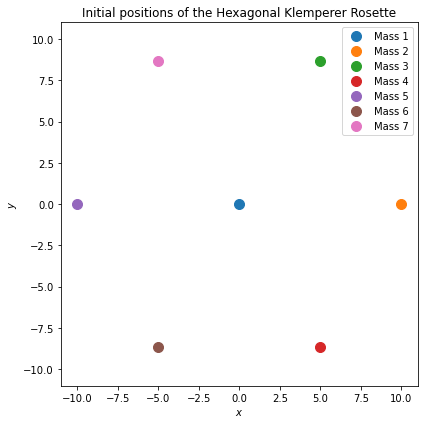

In [28]:
plt.figure(figsize = (6,6), tight_layout = True)

for i in range(Nbodies):
    plt.plot(RN[i,0,0],RN[i,0,1], 'o', markersize = 10, label = rf"Mass {i+1}")
    
plt.title("Initial positions of the Hexagonal Klemperer Rosette")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.ylim(-1.1 * R, 1.1 * R)
plt.xlim(-1.1 * R, 1.1 * R)
plt.legend()

plt.savefig("hexklempinit.jpg", dpi=300)

Now, let's see if this works.

In [91]:
%%time 
# is time allowed?
dt = 1e-5

# takes 4 minutes more or less

RN, VN = Verlet_N_bodies(G, M, RN, VN, dt, N, Nbodies)

CPU times: total: 5min 57s
Wall time: 6min 26s


(-11.0, 11.0)

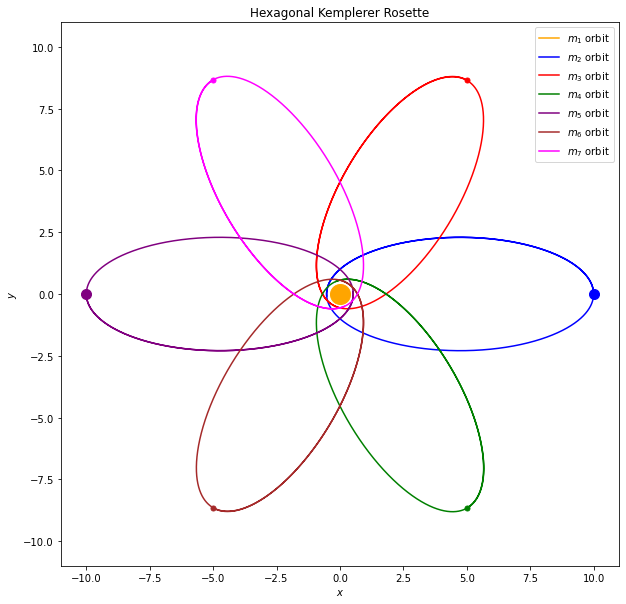

In [137]:
plt.figure(figsize = (10,10))

plotcolors = np.array(['orange','blue', 'red', 'green', 'purple', 'brown', 'magenta'])
markersizes = np.array([20,10,5,5,10,5,5])


for i in range(Nbodies):
    plt.plot(RN[i,:,0], RN[i,:,1], label = fr"$m_{i+1}$ orbit", color = plotcolors[i])
    plt.plot(RN[i,0,0], RN[i,0,1], 'o', markersize = markersizes[i], color = plotcolors[i])


plt.legend()
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")

plt.legend(loc = 'upper right')
plt.title("Hexagonal Kemplerer Rosette")
plt.ylim(-11,11)
plt.xlim(-11,11)


## Half an hour later... (13/03/2023)

This took so long to do on my computer. This will probably be updated to be more correct at some point, so this link is an image of my first orbit:

https://ibb.co/3TVQWBP

As you can see, not very stable. I think what I'll do is decrease the masses 2-7 by a factor of 100. In addition, I will decrease the number of timesteps from 480000 to 240000.

## Nice (13/03/2023)

This looks stunning. Let's just check how many orbits we're doing.

It wasn't enough orbits. Will increase N to 360000.

Text(0.5, 1.0, '$v_x$ of Mass 1 over time')

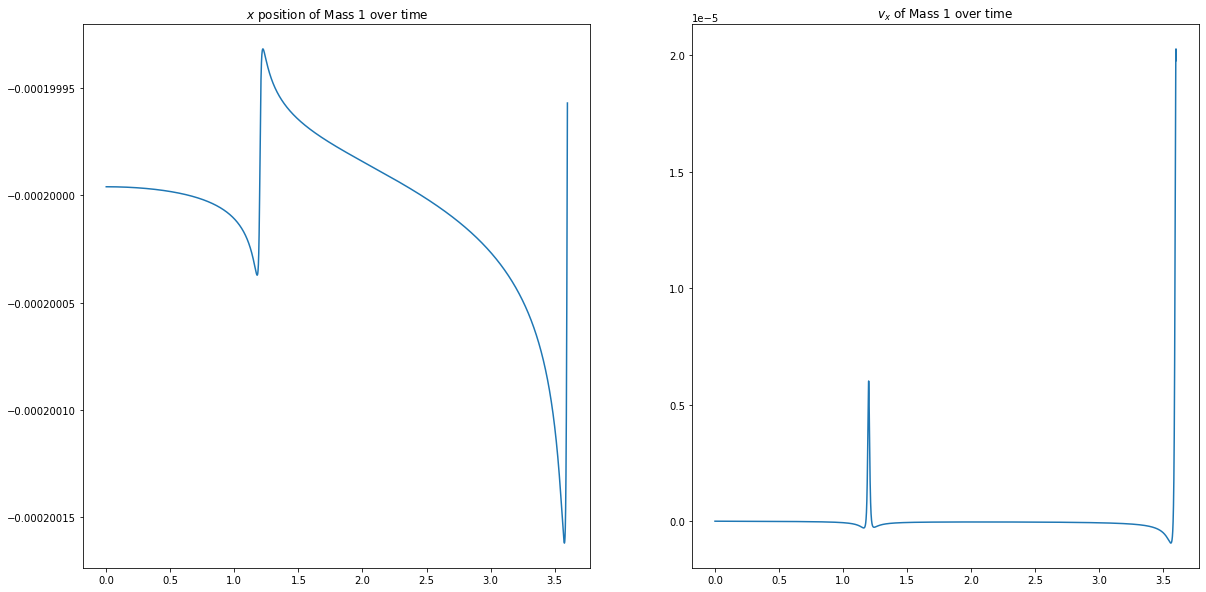

In [177]:
time = np.arange(0, N * dt, dt)

figs, axs = plt.subplots(1,2, figsize = (20,10), tight_layout = False)

axs[0].plot(time, RN[0, :, 0])
axs[0].set_title(r"$x$ position of Mass 1 over time")

axs[1].plot(time, VN[0, :, 0])
axs[1].set_title(r"$v_x$ of Mass 1 over time")

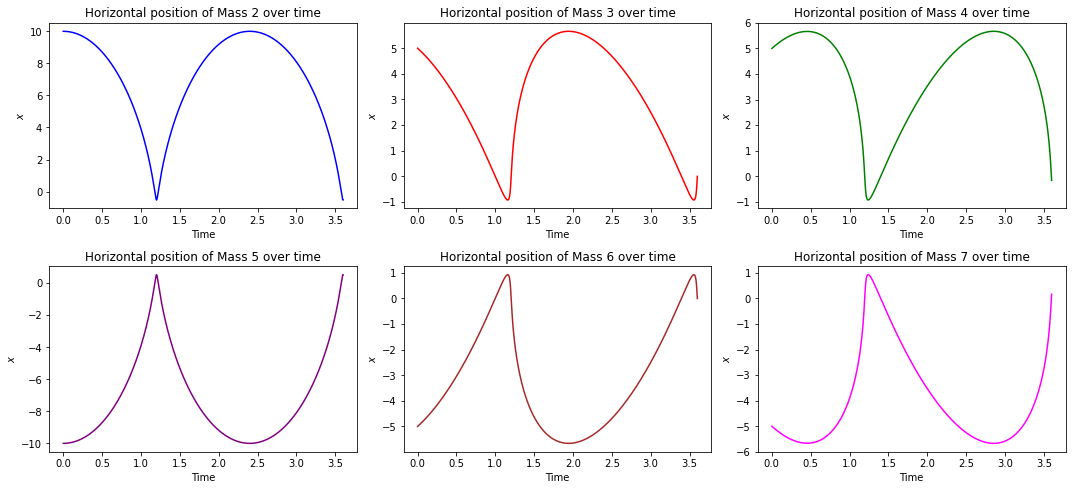

In [178]:
fig = plt.figure(figsize = (15,20), tight_layout = True)

for n in range(1,Nbodies):
    ax = plt.subplot(6,3,n)
    ax.plot(time, RN[n, :, 0], color = plotcolors[n])
    ax.set_title(f"Horizontal position of Mass {n+1} over time")
    ax.set_xlabel(r"Time")
    ax.set_ylabel(r"$x$")

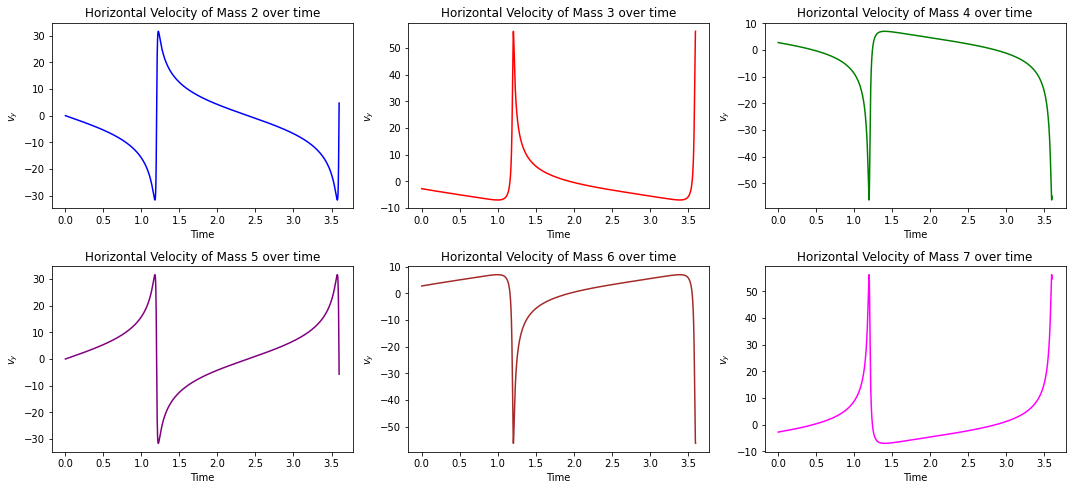

In [180]:
fig = plt.figure(figsize = (15,20), tight_layout = True)

for n in range(1,Nbodies):
    ax = plt.subplot(6,3,n)
    ax.plot(time, VN[n, :, 0], color = plotcolors[n])
    ax.set_title(f"Horizontal Velocity of Mass {n+1} over time")
    ax.set_xlabel(r"Time")
    ax.set_ylabel(r"$v_y$")

Very nice symmetries going on here. 

Let's see the 3-D plot:

Text(0.5, 0, '$z$')

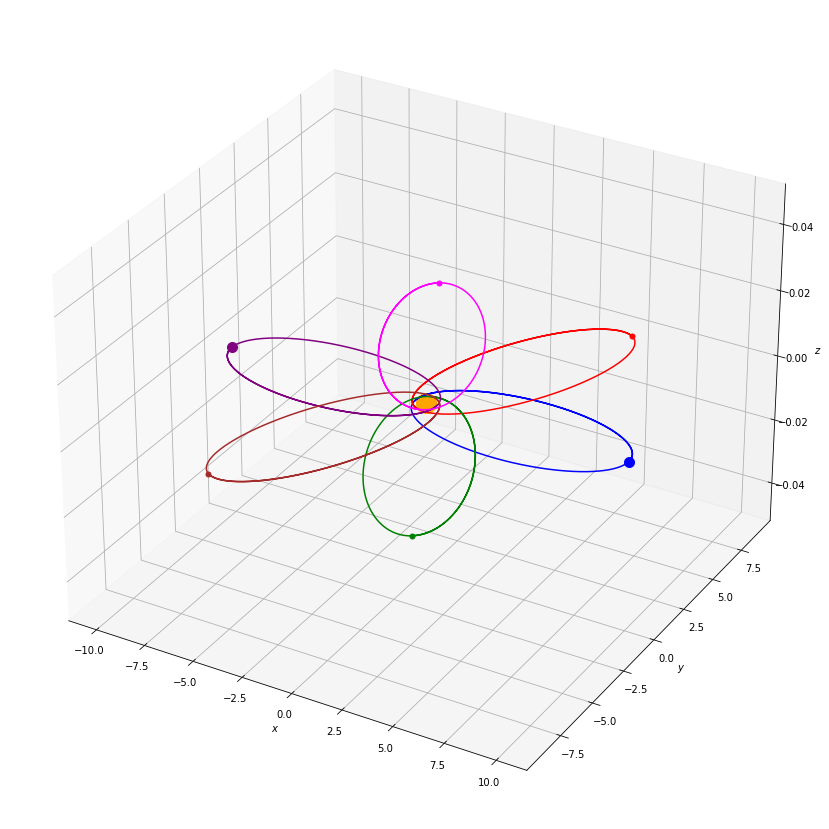

In [181]:
fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')

for i in range(Nbodies):
    ax.plot3D(RN[i,:,0], RN[i, :,1], RN[i, :,2], color = plotcolors[i])
    plt.plot(RN[i,0,0], RN[i,0,1], RN[i,0,2],'o', markersize = markersizes[i], color = plotcolors[i])


ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_zlabel(r"$z$")

The velocity plot as well. Not sure how physically meaningful this is but here we go.

Text(0.5, 0, '$v_z$')

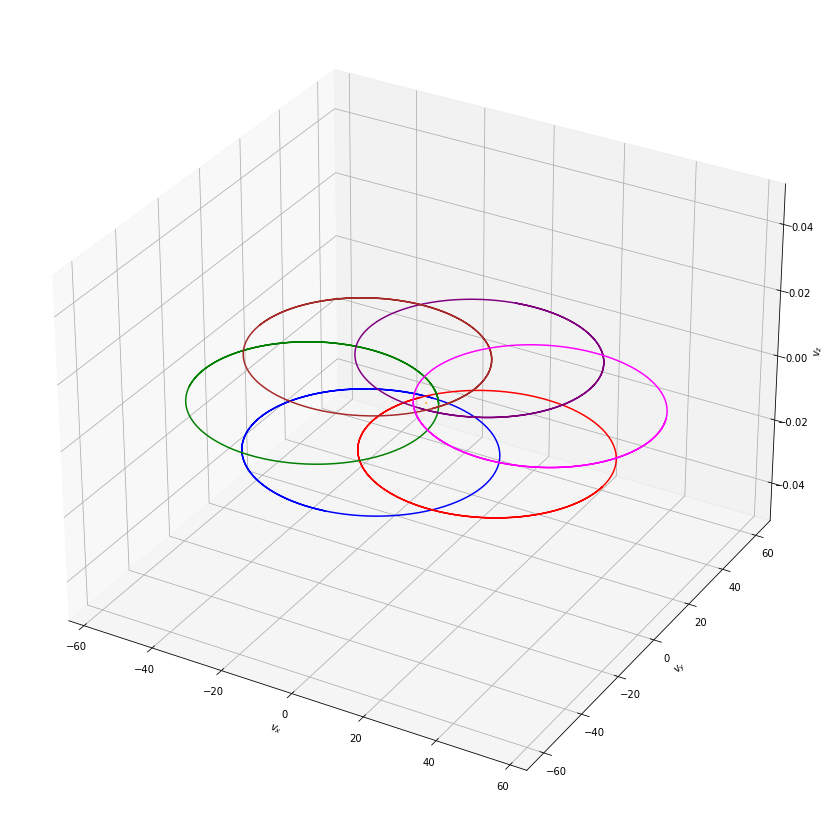

In [150]:
fig = plt.figure(figsize = (15,15))
ax = plt.axes(projection='3d')

for i in range(Nbodies):
    ax.plot3D(VN[i,:,0], VN[i, :,1], VN[i, :,2], color = plotcolors[i])


ax.set_xlabel(r"$v_x$")
ax.set_ylabel(r"$v_y$")
ax.set_zlabel(r"$v_z$")